# Baseline model 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import os 

from sklearn.model_selection import KFold
from tqdm import tqdm 

# import linear models 
from sklearn.linear_model import Lasso, Ridge

# Import data 

In [2]:
print(os.listdir('DATA'))

train = pd.read_csv("DATA/train.csv")
test = pd.read_csv("DATA/test.csv")

train.head()

['house-prices-advanced-regression-techniques.zip', 'data_description.txt', 'train.csv', 'test.csv', 'sample_submission.csv']


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


# Preprocessing 

The data include 1460 samples with 80 features. The features are a mix of continuous and categorical variables, with many entries in the data missing. 

To start, only use continuous valued features 

In [4]:
# exclude categorical features and "id" and "sale price" since these are not features 
features = train.describe().columns.values[1:-1] 
target = ['SalePrice']

# for now just drop entries that have NaNs 
indsnan = np.isnan(np.mean(train[features].values, 0))
features = features[~indsnan]

print("{:.0f} features: \n".format(len(features)), features)

33 features: 
 ['MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold']


In [5]:
# set up training data 
X = np.array(train[features].values, np.float)
y = np.array(train[target].values, np.float)

# standardize data 
# X = (X - np.mean(X, 0)) / np.std(X, 0)

# actually predict centered log_y 
y = np.log(y) - np.mean(np.log(y)) 

In [6]:
def HyperParamOpt1D(X, y, classifier, hyperparams, n_splits):
    # init list of oof prediction performances 
    oof_performance = []
    
    # loop over hyperparameters 
    for hyperparam in hyperparams:
        # set up out of fold 
        oof = np.zeros(X.shape[0])
        
        # pull the first 8 subsets for training 
        skf = KFold(n_splits, shuffle=True)
        skf.get_n_splits(X, y)
        for train_index, val_index in skf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # init classifier 
            clf = classifier(alpha=hyperparam)
            clf.fit(X_train, y_train)
            # make predictions 
            oof[val_index] = clf.predict(X_val).flatten()
            
        # calculate mse 
        mse = np.linalg.norm(oof - y)
        oof_performance.append(mse)
    
    # choose best weights from validation performance 
    best_param = hyperparams[np.argmin(oof_performance)]
    
    # fit best model 
    best_clf = classifier(alpha=best_param)
    best_clf.fit(X, y)
    
    return best_clf, best_param 

In [7]:
# set hyperparams to optimize over 
hyperparams = np.logspace(-4, np.log10(20), 10)

# record out-of-fold predictions for Lasso and Ridge regression
oof_L = np.zeros(X.shape[0])
oof_R = np.zeros(X.shape[0])

# split data into 10 train+validation and testing data sets
skf1 = KFold(n_splits=10, shuffle=True, random_state=123)
skf1.get_n_splits(X, y)
for trainval_index, test_index in tqdm(skf1.split(X), desc="K-Fold"):
    # split the whole dataset into training+validation data and testing sets
    X_trainval, X_test = X[trainval_index], X[test_index]
    y_trainval, y_test = y[trainval_index], y[test_index]
    
    ### LASSO ###
    # see what hyperparameter performs best on validation data 
    best_model, best_param = HyperParamOpt1D(X_trainval, y_trainval, Lasso, hyperparams, n_splits=9)
    
    # make predictions 
    y_pred_test = best_model.predict(X_test)
    #y_pred_test[y_pred_test<=0] = 1e-3
    
    # store predictions
    oof_L[test_index] = y_pred_test.flatten()
    
    ### RIDGE ###
    # see what hyperparameter performs best on validation data 
    best_model, best_param = HyperParamOpt1D(X_trainval, y_trainval, Ridge, hyperparams, n_splits=9)
    
    # make predictions 
    y_pred_test = best_model.predict(X_test)
    #y_pred_test[y_pred_test<=0] = 1e-3
    
    # store predictions
    oof_R[test_index] = y_pred_test.flatten()

K-Fold: 10it [00:03,  2.90it/s]


In [8]:
# calculate performance
mse_ridge = np.linalg.norm(y - oof_R)
mse_lasso = np.linalg.norm(y - oof_R)

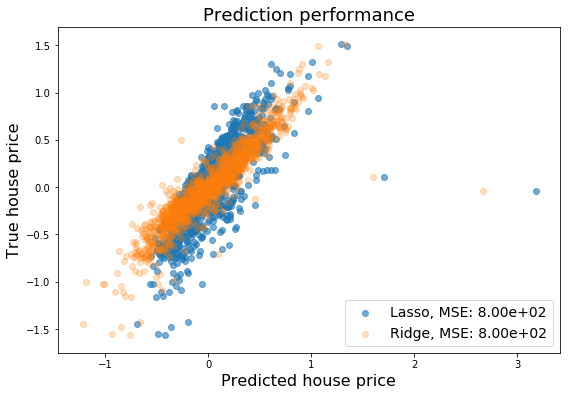

In [9]:
plt.figure(figsize=(9, 6))

plt.scatter(oof_L, y, alpha=.6, label="Lasso, MSE: {:.2e}".format(mse_lasso))
plt.scatter(oof_R, y, alpha=.25, label="Ridge, MSE: {:.2e}".format(mse_ridge))
plt.xlabel("Predicted house price", fontsize=16)
plt.ylabel("True house price", fontsize=16)

plt.legend(fontsize=14)
plt.title("Prediction performance", fontsize=18)
plt.show()